# Can we get this working

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [3]:
import tensorflow as tf

gpu_list = ["/gpu:0", "/gpu:1"]
print(gpu_list)
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

['/gpu:0', '/gpu:1']
Number of devices: 2


In [4]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import pandas as pd
import uproot as ur
import atlas_mpl_style as ampl
ampl.use_atlas_style()

path_prefix = '/home/mswiatlowski/start_tf/caloml-atlas-new/'
plotpath = path_prefix+'regression/Plots/'
modelpath = path_prefix+'regression/Models/'


In [11]:
# import our resolution utilities

import sys
sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

In [12]:
inputpath = '/fast_scratch/atlas_images/v7/'
# rootfiles = ["pi0", "piplus", "piminus"]
rootfiles = ["piplus"]

trees, pdata = mu.setupPionData(inputpath, rootfiles)
npp = len(pdata['piplus'])
print("Number of pi+ events: {}".format(npp))

Number of pi+ events: 435967


In [13]:
pp = pdata['piplus']
pp_tree = trees['piplus']

In [7]:
for ptype in pdata:
    pdata[ptype]['logClusterE'] = np.log10(pdata[ptype].clusterE)
    pdata[ptype]['logECalib'] = np.log10(pdata[ptype].cluster_ENG_CALIB_TOT)


In [8]:
from sklearn.preprocessing import StandardScaler
scaler_cal = StandardScaler()
pdata['piplus']['s_logECalib'] = scaler_cal.fit_transform(pdata['piplus']['logECalib'].to_numpy().reshape(-1,1))
scaler_e = StandardScaler()
pdata['piplus']['s_logClusterE'] = scaler_cal.fit_transform(pdata['piplus']['logClusterE'].to_numpy().reshape(-1,1))

In [9]:
pcells = {
    ifile : {
        layer : mu.setupCells(itree, layer, flatten = False, energyScale = 's_logClusterE', energyFrame = pdata[ifile])
        for layer in mu.cell_meta
    }
    for ifile, itree in trees.items()
}

In [10]:
mu.addCleaning(pdata['piplus'], pcells['piplus'])
ppdata = pdata['piplus'][pdata['piplus'].cleanEmpty].copy()
ppcells = mu.filterCells(pcells['piplus'], pdata['piplus'])

In [11]:
# may not need this if you just scale by s_logECalib to start with?
#mu.standardCellsScalar(ppcells, scaler_cal)

In [12]:
# no this is wrong
# s_ppcells = {
#     layer: mu.standardCellsGeneral(ppcells[layer])[0]
#     for layer in mu.cell_meta
# }

In [13]:
# This is really suspect imo
# mu.normImages(pcells)

In [14]:
mu.createTrainingDatasetsFolds(5, ppdata, ppcells, 's_logClusterE', 20)

0 84704 338813
1 84704 338813
2 84703 338814
3 84703 338814
4 84703 338814


In [15]:
pcellsE23_EMB2G_channels = mu.setupChannelImages(mu.rebinImages(ppcells, (16, 16), layers=['EMB2', 'EMB3']),last=True)
pcellsE1_EMB1G_channels = mu.setupChannelImages(mu.rebinImages(ppcells, (128, 4), layers=['EMB1']),last=True)
pcellsT123_T1G_channels = mu.setupChannelImages(mu.rebinImages(ppcells, (4, 4), layers=['TileBar0', 'TileBar1', 'TileBar2']),last=True)

In [16]:
# pcellsE23_EMB2G_channels = mu.setupChannelImages(mu.rescaleImages(ppcells, (16, 16), layers=['EMB2', 'EMB3']),last=True)
# pcellsE1_EMB1G_channels = mu.setupChannelImages(mu.rescaleImages(ppcells, (128, 4), layers=['EMB1']),last=True)
# pcellsT123_T1G_channels = mu.setupChannelImages(mu.rescaleImages(ppcells, (4, 4), layers=['TileBar0', 'TileBar1', 'TileBar2']),last=True)

digitize makes N bins it'll make sure are evenly populated when split is provided the bins as Y column, nice

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras as keras
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint


Using TensorFlow backend.


In [14]:
# def stretched_tanh(x):
#     beta = 5
#     return beta*K.tanh(x)

In [18]:
def merged_model(droprate=.5):
    with strategy.scope():
        # EMB1 image (convolutional)
        input1 = Input(shape=(128,4,1), name='emb1_input')
        x1 = Convolution2D(32, (3, 3), padding='same', name='emb1_conv2d_1')(input1)
        x1 = Activation('relu')(x1)
        # x1 = Dropout(droprate)(x1)
        x1 = Convolution2D(32, (3, 3), padding='same', name='emb1_conv2d_2')(x1)
        x1 = Activation('relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_3')(x1)
        x1 = Convolution2D(64, (3, 3), padding='same', name='emb1_conv2d_3')(x1)
        x1 = Activation('relu')(x1)
        #x1 = Dropout(droprate)(x1)
        x1 = Convolution2D(64, (3, 3), padding='same', name='emb1_conv2d_4')(x1)
        x1 = Activation('relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_5')(x1)
        x1 = Convolution2D(128, (2, 2), padding='same', name='emb1_conv2d_6')(x1)
        x1 = Activation('relu')(x1)
        x1 = Convolution2D(128, (2, 2), padding='same', name='emb1_conv2d_7')(x1)
        x1 = Activation('relu')(x1)
        x1 = MaxPool2D(pool_size=(2, 1), padding='same', name='emb1_maxpool_8')(x1)
        x1 = Dropout(droprate, name='emb1_dropout_4')(x1)
        x1 = Flatten(name='emb1_flatten_9')(x1)
        x1 = Dense(128, activation='relu', name='emb1_dense_9')(x1)

        # EMB23 image (convolutional)
        input2 = Input(shape=(16,16,2), name='emb23_input')
        x2 = Convolution2D(32, (1, 1), padding='same', name='emb23_conv1d_1')(input2)
        x2 = Activation('relu')(x2)
        # x2 = Dropout(droprate)(x2)
        x2 = Convolution2D(64, (2, 2), padding='same', name='emb23_conv2d_2')(x2)
        # x2 = Dropout(droprate)(x2)
        x2 = MaxPool2D(pool_size=(2, 2), padding='same', name='emb23_maxpool_3')(x2)
        x2 = Convolution2D(128, (2, 2), padding='same', name='emb23_conv2d_4')(x2)
        x2 = Activation('relu')(x2)
        # x2 = Dropout(droprate)(x2)
        x2 = Convolution2D(128, (2, 2), padding='same', name='emb23_conv2d_5')(x2)
        x2 = Activation('relu')(x2)
        x2 = MaxPool2D(pool_size=(2, 2), padding='same', name='emb23_maxpool_6')(x2)
        x2 = Dropout(droprate, name='emb23_dropout_4')(x2)
        x2 = Flatten(name='emb23_flatten_7')(x2)
        x2 = Dense(128, activation='relu', name='emb23_dense_8')(x2)

        # tiles image (convolutional)
        input3 = Input(shape=(4,4,3), name='tiles_input')
        x3 = Convolution2D(32, (1, 1), padding='same', name='tiles_conv1d_1')(input3)
        x3 = Activation('relu')(x3)
        # x3 = Dropout(droprate)(x3)
        x3 = Convolution2D(64, (2, 2), padding='same', name='tiles_conv2d_2')(x3)
        x3 = Activation('relu')(x3)
        # x3 = Dropout(droprate)(x3)
        x3 = Convolution2D(128, (2, 2), padding='same', name='tiles_conv2d_3')(x3)
        x3 = Activation('relu')(x3)
        x3 = MaxPool2D(pool_size=(2, 2), padding='same', name='tiles_maxpool_4')(x3)
        x3 = Dropout(droprate, name='tiles_dropout_4')(x3)
        x3 = Flatten(name='tiles_flatten_5')(x3)
        x3 = Dense(128, activation='relu', name='tiles_dense_6')(x3)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x2, x3], name='concatenate') 
        x = Dropout(droprate, name='concate_dropout_5')(x)
        x = Dense(64, name='concated_dense_1')(x)    
        x = Activation('relu')(x)
        x = Dropout(droprate, name='dense_dropout_6')(x)

        # final output
        output = Dense(1, activation='linear', name='dense_output')(x)
        # output = Dense(1, activation=stretched_tanh, name='dense_output')(x)
        # output = 5*tf.math.tanh(x)   # 0 to +5 range

        model = Model(inputs = [input1, input2, input3], outputs = [output])

        # compile model
        # model = multi_gpu_model(model, gpus=4)
        opt = Adam(lr=1e-5)
        model.compile(loss='mse', optimizer=opt, metrics=['mae', 'mse'])
        return model

In [19]:
# def norm(x, xmax, xmin):
#     xmin = xmin - np.finfo(np.float32).eps
#     return (x-xmin)/(xmax-xmin)

# def denorm(x, xmax, xmin):
#     xmin = xmin - np.finfo(np.float32).eps
#     return x*(xmax-xmin) + xmin

# ppdata['logECalib'] = np.log10(ppdata.cluster_ENG_CALIB_TOT)
# calib_max = np.amax(ppdata.logECalib)
# calib_min = np.amin(ppdata.logECalib)
# ppdata['s_logECalib'] = norm(ppdata.logECalib, xmax = calib_max, xmin = calib_min)

In [15]:
history_cnn = {}
models_cnn = {}
for f in range(5):
    models_cnn[f] = merged_model(0.2)
    models_cnn[f].summary()
    train = str(f)+'_train'
    test = str(f)+'_test'

    modelsave = modelpath + 'cnn_mnorm_fold{}_best.h5'.format(f)
    checkpoint = ModelCheckpoint(modelsave, monitor='val_loss', save_best_only=True, save_weights_only=False)

    history_cnn[f] = models_cnn[f].fit([pcellsE1_EMB1G_channels[ppdata[train]], 
                                pcellsE23_EMB2G_channels[ppdata[train]], 
                                pcellsT123_T1G_channels[ppdata[train]]],
                                ppdata[ppdata[train]].s_logECalib.to_numpy(),
                                validation_data=([pcellsE1_EMB1G_channels[ppdata[test]], 
                                                    pcellsE23_EMB2G_channels[ppdata[test]], 
                                                    pcellsT123_T1G_channels[ppdata[test]]], 
                                                    ppdata[ppdata[test]].s_logECalib.to_numpy()),
                                epochs=150,
                                batch_size = 128*ngpu,
                                verbose=2,
                                callbacks = [checkpoint]
                                # use_multiprocessing=False
                                )

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
emb1_input (InputLayer)         [(None, 128, 4, 1)]  0                                            
__________________________________________________________________________________________________
emb1_conv2d_1 (Conv2D)       

NameError: name 'pcellsE1_EMB1G_channels' is not defined

In [37]:
ppdata['predict_p1_d02'] = np.zeros(len(ppdata))
for f in range(5):
    test = str(f)+'_test'
    val = 'predict_p1_d02_{}'.format(f)
    ppdata[ppdata[test]].predict_p1_d02 = 10.**(denorm(models_cnn[f].predict([pcellsE1_EMB1G_channels[ppdata[test]], pcellsE23_EMB2G_channels[ppdata[test]], pcellsT123_T1G_channels[ppdata[test]]]), xmax = calib_max, xmin = calib_min))
    ppdata[val] =  10.**(denorm(models_cnn[f].predict([pcellsE1_EMB1G_channels, pcellsE23_EMB2G_channels, pcellsT123_T1G_channels]), xmax = calib_max, xmin = calib_min))
    ppdata[val+'_EoverCalib'] = ppdata[val] / ppdata.cluster_ENG_CALIB_TOT

ppdata['predict_p1_d02_EoverCalib'] = ppdata.predict_p1_d02 / ppdata.cluster_ENG_CALIB_TOT

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

<Figure size 576x432 with 0 Axes>

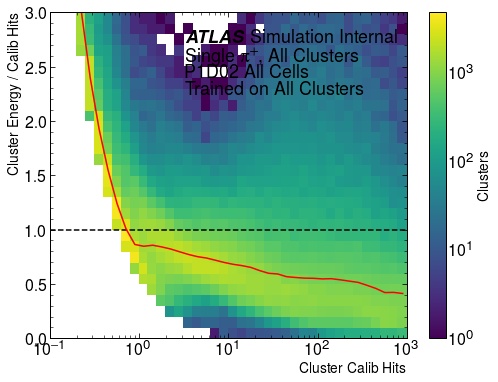

In [38]:
xcenter, medReg_p1_d02 = ru.responsePlot(ppdata.cluster_ENG_CALIB_TOT, ppdata.predict_p1_d02_0_EoverCalib,
                 plotpath+'hist_2D_calib_vs_ratioReg_p1_d02_kfold5_profile.pdf',
                 'median',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'P1D02 All Cells'},
                             {'x': 0.38, 'y': 0.75, 'text': 'Trained on All Clusters'}])

## Try Dense model, with rebinned images

In [15]:
def dense_model(droprate=.5):
    with strategy.scope():
        # EMB1 image (convolutional)
        emb1_dense = dn.DenseNet(input_shape=(128,4,1), depth=13, 
                             nb_dense_block=1, growth_rate=16, dropout_rate=droprate,
                             include_top=False, model_prefix='emb1_')
        input1 = emb1_dense.input
        x1 =  emb1_dense.output
        x1 = Flatten(name='emb1_flatten')(x1)
        x1 = Dense(128, activation='relu', name='emb1_dense')(x1)

        # EMB23 image (convolutional)
        # input2 = Input(shape=(16,16,2), name='emb23_input')
        emb23_dense = dn.DenseNet(input_shape=(16,16,2), depth=13, 
                                nb_dense_block=1, growth_rate=16, dropout_rate=droprate,
                                include_top=False, model_prefix='emb23_')
        input2 = emb23_dense.input
        x2 =  emb23_dense.output
        x2 = Flatten(name='emb23_flatten')(x2)
        x2 = Dense(128, activation='relu', name='emb23_dense')(x2)

        # tiles image (convolutional)
        # input3 = Input(shape=(4,4,3), name='tiles_input')
        tiles_dense = dn.DenseNet(input_shape=(4,4,3), depth=13, 
                                nb_dense_block=1, growth_rate=16, dropout_rate=droprate,
                                include_top=False, model_prefix='tiles_')
        input3 = tiles_dense.input
        x3 =  tiles_dense.output
        x3 = Flatten(name='tiles_flatten')(x3)
        x3 = Dense(128, activation='relu', name='tiles_dense')(x3)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x2, x3], name='concatenate_cnn') 
        x = Dropout(droprate, name='concate_dropout_5')(x)
        x = Dense(64, name='concated_dense_1')(x)    
        x = Activation('relu')(x)
        x = Dropout(droprate, name='dense_dropout_6')(x)

        # final output
        output = Dense(1, activation=stretched_tanh, name='dense_output')(x)
        # output = 5*tf.math.tanh(x)   # 0 to +5 range

        model = Model(inputs = [input1, input2, input3], outputs = [output])

        # compile model
        # model = multi_gpu_model(model, gpus=4)
        opt = Adam(lr=5e-6)
        model.compile(loss='mse', optimizer=opt, metrics=['mae', 'mse'])
        return model

In [16]:
from util import densenet as dn

In [17]:
dense_02 = dense_model(0.2)
dense_02.summary()

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 4, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)         

In [18]:
models_dense_02 = {}
for f in range(5):
    models_dense_02[f] = dense_model(0.2)
    models_dense_02[f].summary()

______________________________
dropout_43 (Dropout)            (None, 4, 4, 16)     0           tiles_dense_0_1_conv2D[0][0]     
__________________________________________________________________________________________________
concatenate_37 (Concatenate)    (None, 128, 4, 64)   0           concatenate_36[0][0]             
                                                                 dropout_37[0][0]                 
__________________________________________________________________________________________________
concatenate_40 (Concatenate)    (None, 16, 16, 64)   0           concatenate_39[0][0]             
                                                                 dropout_40[0][0]                 
__________________________________________________________________________________________________
concatenate_43 (Concatenate)    (None, 4, 4, 64)     0           concatenate_42[0][0]             
                                                                 dropout_43[0]

In [21]:
history_dense_02 = {}

for f in range(5):
    train = '{}_train'.format(f)
    test = '{}_test'.format(f)

    modelsave = modelpath + 'dense_fold{}_best.h5'.format(f)
    checkpoint = ModelCheckpoint(modelsave, monitor='val_loss', save_best_only=True, save_weights_only=False)

    history_dense_02[f] = models_dense_02[f].fit([pcellsE1_EMB1G_channels[ppdata[train]], 
                                pcellsE23_EMB2G_channels[ppdata[train]], 
                                pcellsT123_T1G_channels[ppdata[train]]],
                                ppdata[ppdata[train]].s_logECalib.to_numpy(),
                                validation_data=([pcellsE1_EMB1G_channels[ppdata[test]], 
                                                    pcellsE23_EMB2G_channels[ppdata[test]], 
                                                    pcellsT123_T1G_channels[ppdata[test]]], 
                                                    ppdata[ppdata[test]].s_logECalib.to_numpy()),
                                epochs=150,
                                batch_size = 128*ngpu,
                                verbose=2,
                                callbacks = [checkpoint]
                                # use_multiprocessing=False
                                )

les
Epoch 1/150
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 22 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
329212/329212 - 43s - loss: 1.0006 - mae: 0.6373 - mse: 0.9801 - val_loss: 0.1158 - val_mae: 0.2497 - val_mse: 0.0953
Epoch 2/150
329212/329212 - 34s - loss: 0.2245 - mae: 0.3117 - mse: 0.2040 - val_loss: 0.0816 - val_mae: 0.2058 - val_mse: 0.0611
Epoch 3/150
329212/329212 - 34s - loss: 0.1251 - mae: 0.2285 - mse: 0.1047 - val_loss: 0.0645 - val_mae: 0.1774 - val_mse: 0.0440
Epoch 4/150
329212/329212 - 34s - loss: 0.0874 - mae: 0.1846 - mse: 0.0670 - val_loss: 0.0556 - val_mae: 0.1610 - val_mse: 0.0352
Epoch 5/150
329212/329212 - 34s - loss: 0.0665 - mae: 0.1543 - mse: 0.0462 - val_loss: 0.0440 - val_mae: 0.1315 - val_mse: 0.0238
Epoch 6/150
329212/329212 - 34s - loss: 0.

## Try the DNN with folds???

In [14]:

# regression variables: define up here to make it easier for later swapping

pp['logE'] = np.log(pp.clusterE)
pp['logECalib'] = np.log(pp.cluster_ENG_CALIB_TOT)
from sklearn.preprocessing import StandardScaler
# create scaler
scaler_e = StandardScaler()
scaler_cal = StandardScaler()
# fit and transform in one step
pp['s_logE'] = scaler_e.fit_transform(pp['logE'].to_numpy().reshape(-1,1))
pp['s_logECalib'] = scaler_cal.fit_transform(pp['logECalib'].to_numpy().reshape(-1,1))

In [15]:
scaler_eta = StandardScaler()
pp['s_eta'] = scaler_eta.fit_transform(pp.clusterEta.to_numpy().reshape(-1,1))

In [16]:
EMB1_cells = mu.setupCells(pp_tree, 'EMB1') # implicitly flatten
EMB2_cells = mu.setupCells(pp_tree, 'EMB2')
EMB3_cells = mu.setupCells(pp_tree, 'EMB3') # implicitly flatten

TileBar0_cells = mu.setupCells(pp_tree, 'TileBar0') # implicitly flatten
TileBar1_cells = mu.setupCells(pp_tree, 'TileBar1') # implicitly flatten
TileBar2_cells = mu.setupCells(pp_tree, 'TileBar2') # implicitly flatten

In [17]:
combine_All_cells = np.concatenate((EMB1_cells, EMB2_cells, EMB3_cells, TileBar0_cells, TileBar1_cells, TileBar2_cells), axis=1)
s_All_cells, scaler_All_cells = mu.standardCells(combine_All_cells, ['EMB1', 'EMB2', 'EMB3', 'TileBar0', 'TileBar1', 'TileBar2'])
All_input = np.column_stack((pp['s_logE'],pp['s_eta'],s_All_cells))

In [18]:
# mu.createTrainingDatasetsFolds(5, pp, 's_logE', 20)
mu.createTrainingDatasetsFolds(5, pp)

0 87194 348773
1 87194 348773
2 87193 348774
3 87193 348774
4 87193 348774


In [25]:
def baseline_nn_All_model():
    number_pixels = 512 + 256 + 128 + 16 + 16 +8
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels + 2
#     if number_pixels < 128:
#         used_pixels = 128
        model.add(Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(used_pixels, activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-5)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])
    return model

In [26]:
models_dnn = {}
for f in range(5):
    models_dnn[f] = baseline_nn_All_model()
    models_dnn[f].summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 938)               880782    
_________________________________________________________________
dense_21 (Dense)             (None, 938)               880782    
_________________________________________________________________
dense_22 (Dense)             (None, 469)               440391    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 470       
Total params: 2,202,425
Trainable params: 2,202,425
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 938)               880782    
______________________

<Figure size 576x432 with 0 Axes>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


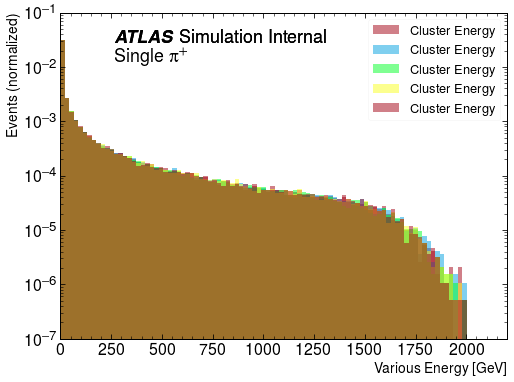

In [21]:
pu.histogramOverlay(frames = [pp[pp['0_test']], pp[pp['1_test']], pp[pp['2_test']], pp[pp['3_test']], pp[pp['4_test']]],
                    data =  ['clusterE', 'clusterE', 'clusterE', 'clusterE', 'clusterE'],
                    labels =['Cluster Energy', 'Cluster Energy', 'Cluster Energy', 'Cluster Energy', 'Cluster Energy'],
                    xlabel = 'Various Energy [GeV]',
                    ylabel = 'Events (normalized)',
                    # figfile = plotpath + '/hist_energy.pdf',
                    x_min = 0, x_max = 2200, xbins = 100, normed = True, y_log = True,
                    atlas_x = 0.12, atlas_y = 0.95, simulation = True,
                    textlist = [{'x': 0.12, 'y': 0.85, 'text': 'Single $\pi^{+}$'}])

In [27]:
history_dnn = {}

for f in range(5):
    train = '{}_train'.format(f)
    test = '{}_test'.format(f)

    modelsave = modelpath + 'dnn_fold{}_best_foldtest_lr1en5.h5'.format(f)
    checkpoint = ModelCheckpoint(modelsave, monitor='val_loss', save_best_only=True, save_weights_only=False)

    history_dnn[f] = models_dnn[f].fit(All_input[pp[train]], pp[pp[train]].s_logECalib.to_numpy(),
                                validation_data=(All_input[pp[test]], 
                                                    pp[pp[test]].s_logECalib.to_numpy()),
                                epochs=200,
                                batch_size = 200*ngpu,
                                verbose=2,
                                callbacks = [checkpoint]
                                # use_multiprocessing=False
                                )

: 0.0170
Epoch 48/200
348774/348774 - 8s - loss: 0.0455 - mae: 0.0885 - mse: 0.0455 - val_loss: 0.0172 - val_mae: 0.0823 - val_mse: 0.0172
Epoch 49/200
348774/348774 - 8s - loss: 0.0963 - mae: 0.0920 - mse: 0.0963 - val_loss: 0.0182 - val_mae: 0.0825 - val_mse: 0.0182
Epoch 50/200
348774/348774 - 8s - loss: 0.0329 - mae: 0.0821 - mse: 0.0329 - val_loss: 0.0208 - val_mae: 0.0865 - val_mse: 0.0208
Epoch 51/200
348774/348774 - 8s - loss: 0.0352 - mae: 0.0810 - mse: 0.0352 - val_loss: 0.0259 - val_mae: 0.1170 - val_mse: 0.0259
Epoch 52/200
348774/348774 - 8s - loss: 0.0533 - mae: 0.0905 - mse: 0.0533 - val_loss: 0.0299 - val_mae: 0.1061 - val_mse: 0.0299
Epoch 53/200
348774/348774 - 8s - loss: 0.0377 - mae: 0.0852 - mse: 0.0377 - val_loss: 0.0202 - val_mae: 0.0876 - val_mse: 0.0202
Epoch 54/200
348774/348774 - 8s - loss: 0.0483 - mae: 0.0867 - mse: 0.0483 - val_loss: 0.0294 - val_mae: 0.1043 - val_mse: 0.0294
Epoch 55/200
348774/348774 - 8s - loss: 0.0801 - mae: 0.0889 - mse: 0.0801 - val_

In [23]:
pp['predict_dnn'] = np.zeros(len(pp))
for f in range(5):
    test = '{}_test'.format(f)
    value = 'predict_dnn_{}'.format(f)
    pp[pp[test]].predict_dnn = np.exp(scaler_cal.inverse_transform(models_dnn[f].predict(All_input[pp[test]])))
    pp[value] = np.exp(scaler_e.inverse_transform(models_dnn[f].predict(All_input)))
    pp[value+'_EoverCalib'] = pp[value] / pp.cluster_ENG_CALIB_TOT

pp['predict_dnn_EoverCalib'] = pp.predict_dnn / pp.cluster_ENG_CALIB_TOT

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<Figure size 576x432 with 0 Axes>

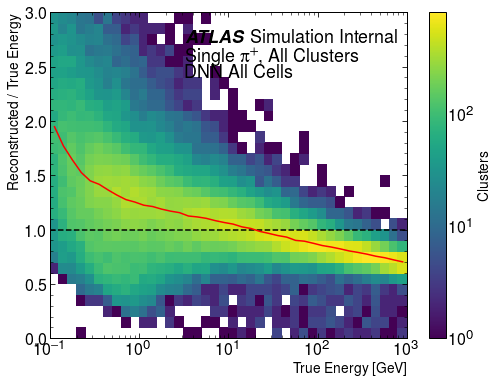

In [24]:
xcenter, medRegDNN = ru.responsePlot(pp[pp['1_test']].cluster_ENG_CALIB_TOT, pp[pp['1_test']].predict_dnn_1_EoverCalib,
                #  plotpath+'hist_2D_calib_vs_ratioReg_DNN_profile.pdf',
                 'median',
                 xlabel = 'True Energy [GeV]', ylabel = 'Reconstructed / True Energy',
                 atlas_x = 0.38, atlas_y = 0.95, simulation = True,
                 textlist = [{'x': 0.38, 'y': 0.85, 'text': 'Single $\pi^{+}$, All Clusters'},
                             {'x': 0.38, 'y': 0.8,  'text': 'DNN All Cells'}])

In [26]:
mu.splitFrameTVT(pp, trainfrac = 0.7) 

In [35]:
model_dnn = baseline_nn_All_model()

In [36]:
history_dnn = model_dnn.fit(All_input[pp.train], pp[pp.train].s_logECalib.to_numpy(),
                                validation_data=(All_input[pp.val], 
                                                    pp[pp.val].s_logECalib.to_numpy()),
                                epochs=200,
                                batch_size = 200*ngpu,
                                verbose=2
                                # callbacks = [checkpoint]
                                # use_multiprocessing=False
                                )

Train on 305176 samples, validate on 43598 samples
Epoch 1/200
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
INFO:tensorflow:batch_all_reduce: 8 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
305176/305176 - 11s - loss: 0.6305 - mae: 0.6204 - mse: 0.6305 - val_loss: 0.4616 - val_mae: 0.5414 - val_mse: 0.4616
Epoch 2/200
305176/305176 - 7s - loss: 0.3977 - mae: 0.4883 - mse: 0.3977 - val_loss: 0.3329 - val_mae: 0.4480 - val_mse: 0.3329
Epoch 3/200
305176/305176 - 7s - loss: 0.2912 - mae: 0.4132 - mse: 0.2912 - val_loss: 0.2432 - val_mae: 0.3816 - val_mse: 0.2432
Epoch 4/200
305176/305176 - 7s - loss: 0.2118 - mae: 0.3518 - mse: 0.2118 - val_loss: 0.1768 - val_mae: 0.3244 - val_mse: 0.1768
Epoch 5/200
305176/305176 - 7s - loss: 0.1540 - mae: 0.2998 - mse: 0.1540 - val_loss: 0.1314 - val_mae: 0.2774 - val_mse: 0.1314
E

KeyboardInterrupt: 